# Load the necessary libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import logging

# To suppress the warning messages from lal
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

sys.path.append('..')
from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Offset import *
from Triangle.Plot import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import * 

import healpy as hlp 

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['font.family'] = 'serif'

logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

import multiprocessing
print('number of cpus =', multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


number of cpus = 32


# Define the parameters for the simulation 

1. fsample: the sampling rate of the data 
2. data_time: the total time of the data 
3. ifo_drop_time1, ifo_drop_time2: the time to drop the invalid data in the first and second interferometer 
4. tdi_drop_time1, tdi_drop_time2: the time to drop the invalid data in the first and second TDI channel 
5. size: the total size of the data 
6. interp_order: the order of the interpolation 

In [37]:
fsample = 1/10  # TODO: 不知道这个fsample是啥意思，以及default是多少
data_time = 14 * DAY # 110 * DAY 
# TODO: 不知道ifo_drop_time1, ifo_drop_time2, tdi_drop_time1, tdi_drop_time2是啥意思，以及default是多少
ifo_drop_time1 = 100 # in this tutorial we do not let the code drop the invalid data, but remove them by hand instead 
ifo_drop_time2 = 100
tdi_drop_time1 = 100
tdi_drop_time2 = 100 
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31 # TODO: 不知道这个interp_order是啥意思，以及default是多少

ranging_process = False # whether to combine PRN and sideband to get high-precision inter-spacecraft ranges that can be used in TDI,
quick_sim = False  # FIXME: Set to False if you want to customize the simulation (e.g. add glitch to the acceleration noise) 
TDI_method = 'fast' # 'basic', 'fast', 'path', 'operator'

# Define the orbit, offset, and noise 

In [3]:
# Note: MicroSateOrbitEclipticTCB is the orbit of the spacecraft in the ecliptic plane, and TCB is the global time frame used in GW data analysis. 
# Currently, the orbit data is only available for 110 days.
# TODO: 不知道tstart 的 default是多少，就是0么？
orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB', dt=DAY, tstart=10.*DAY, pn_order=2) # here we start from the 10th day of orbit 
offset = OffsetFunctions(laser_flag=False, clock_flag=False)  # no clock drifts
noise = InstrumentalPSDs(unit='ffd') 

# Define the GW source 

## 1. Initialize GB waveforms

In [4]:
gb = GB(
    A=1.39879192e-22, 
    f=0.00984299, 
    fdot=4.31168731e-16, 
    iota=2.29680093, 
    phi0=0.79960729
    )

In [5]:
lam = 4.50950561
beta = -0.30076513
psi = 3.08152927

# for multiple sources, gw should be a list of GW objects, and the responses of them can be calculated in parallel
gw_gb = [GW(GWfunc=gb, orbit=orbit, ext_params=[lam, beta, psi])]

## 2. Initialize MBHB waveforms

In [6]:
# set parameters 
Mc = 400000.0
q = 0.3640815267051051
spin1z = 0.7899406190510447
spin2z = 0.015424596359292053
tc = 5. * DAY 
phic = 3.2535342675592966
D = 106039.10941463517
inc = 1.4495086550199021

# set waveform template 
approx = 'IMRPhenomD'

# set the sampling rate to generate unprojedted polarizations
dt = 1.

# initialize MBHB waveform
mbhb = MBHB(approx_method=approx, modes=None)
mbhb(Mc=Mc, q=q, spin1z=spin1z, spin2z=spin2z, tc=tc, phic=phic, D=D, inc=inc, dt=dt)

In [7]:
lam = 3.032776598141215
beta = -1.1817968279048852
psi = 0.2409146690555858

# for multiple sources, gw should be a list of GW objects, and the responses of them can be calculated in parallel
gw_mbhb = [GW(GWfunc=mbhb, orbit=orbit, ext_params=[lam, beta, psi])]

## 3. Initialize custom GW waveform

In [8]:
from scipy.interpolate import InterpolatedUnivariateSpline

class GeneralWaveform():
    def __init__(self, tdata, hpdata, hcdata, t0=0):
        tdata_int = tdata - tdata[0] + t0 # shift the starting time to t0 
        self.hpfunc = InterpolatedUnivariateSpline(x=tdata_int, y=hpdata, k=5, ext='zeros')
        self.hcfunc = InterpolatedUnivariateSpline(x=tdata_int, y=hcdata, k=5, ext='zeros')

In [9]:
waveform_data = np.load("../GWData/Demo_MBHB_waveform_data.npy")
tdata, hpdata, hcdata = waveform_data.T 

waveform_wrapper = GeneralWaveform(tdata, hpdata, hcdata)

# randomize extrinsic parameters 
lam = np.random.uniform(0, TWOPI) 
beta = np.arcsin(np.random.uniform(-1, 1))
psi = np.random.uniform(0, PI)

gw_custom = [GW(GWfunc=waveform_wrapper, orbit=orbit, ext_params=[lam, beta, psi])]

## 4. Initialize SGWB signals

In [10]:
# define the SGWB fractional density 
def Omega_SGWB(f, Omega0, f0, n): 
    return Omega0 * (f / f0) ** n 

# define the PSD of polarizations 
def S_SGWB(f, Omega0=1e-11, f0=3.162e-3, n=-1.): 
    Omega = Omega_SGWB(f, Omega0, f0, n)
    return 3. * H0 ** 2 / 4. / np.pi ** 2 / f ** 3 * Omega * 1e6 / MPC ** 2 

# get the sky locations 
NSIDE = 5 # TODO: 不知道这个NSIDE是啥意思，以及default是多少
NPIX = hlp.nside2npix(NSIDE)
print("number of directions:", NPIX)
colatitude, longitude = hlp.pix2ang(nside=NSIDE, ipix=np.arange(NPIX))
latitude = np.pi / 2. - colatitude

# generate stochastic signals in all the directions 
sgwb_generator = GeneralNoise(S_SGWB)
tdata = np.arange(size) / fsample
gw_sgwb = [] 
for i in tqdm(range(NPIX)): 
    hp_k = sgwb_generator(fsample=fsample, size=size) / np.sqrt(NPIX * 2.) # the relationship between h and SGW might vary in the literature, differing by a constant factor.
    hc_k = sgwb_generator(fsample=fsample, size=size) / np.sqrt(NPIX * 2.)
    Waveform_k = GeneralWaveform(tdata=tdata, hpdata=hp_k, hcdata=hc_k)
    GW_k = GW(orbit=orbit, ext_params=[longitude[i], latitude[i], 0.], GWfunc=Waveform_k) # here we set psi=0 since it is absorbed to h+ and hx
    gw_sgwb.append(GW_k)

number of directions: 300


100%|██████████| 300/300 [00:13<00:00, 22.17it/s]


## 5. Combine all GW signals

In [11]:
# for multiple sources, gw should be a list of GW objects, and the responses of them can be calculated in parallel
gw = gw_gb + gw_mbhb + gw_custom + gw_sgwb

# Define the interferometer

In [12]:
# TODO: 不知道这个 *_noise 是啥意思，以及每个default应该是啥
# TODO: detrend_order 和 telemetry_downsample 的 default是None么？
# TODO: time_frame 的 default就是ProperTime么？不需要我关注他取别的值么？
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime', # the time frame of data, 'ProperTime' for the proper times of SCs, 'ClockTime' for the times of on-board clocks (with clock drifts and jitters relative to the proper times) 
    garbage_time1=ifo_drop_time1, # remove invalid data at the beginning 
    garbage_time2=ifo_drop_time2, # remove invalid data at the end 
    telemetry_downsample=None, # downsampling factor = f_before / f_after 
    detrend_order=None, # order of polynomial used to detrend. detrending with polynomial is only suitable for short-duration data. 
    acc_noise=True, # switch of acceleration noise
    ro_noise=True, # switch of readout noise (all types of ifos)
    laser_noise=True, # switch of laser frequency noise 
    clock_noise=True, # switch of clock noise (also need to set time_frame = 'ClockTime')
    ob_noise=False, # switch of optical bench displacement noise 
    bl_noise=False, # switch of fibre backlink noise 
    op_noise=False, # switch of optical path noise (all optical paths)
    ranging_noise=False, # switch of pseudo ranging noise 
    modulation_noise=False, # switch of sideband modulation noise 
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw,
    fplan=fplan, # set laser locking scheme and frequency plan 
    order=interp_order, # order of lagrange interpolation used to calculate time delays, 31 for noisy data and lower for offset-only or GW-only data 
    pool=pool,
    clean_memory=True, # whether to clean some intermediate variables to save memory 
    )

INFO:Triangle.Interferometer:Simulating data with sampling frequency 0.1 Hz.
INFO:Triangle.Interferometer:size = 121000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:	laser_noise
INFO:Triangle.Interferometer:	clock_noise
INFO:Triangle.Interferometer:The simulation contains GW signal.


In [13]:
if quick_sim:
    # simulate interferometric measurements 
    ifo.SimulateInterferometers()
else:
    # break the ifo.SimulateInterferometer() function into steps so that we can modify the intermediate variables 
    ifo.SimulateBasicNoise()

    # FIXME: You can modify the amplitudes of acceleration noises here 
    for key in MOSA_labels:
        ifo.BasicNoise['ro_sci_c_noise'][key] *= np.random.uniform(1.5, 2.5)  
    ifo.SimulateRangeAndClock()

    # FIXME: You also can add glitch to the acceleration noise here 
    glitch = Glitch(fsample=ifo.fsample)
    glitch_simulation_time = ifo.proper_time['1'] # generate glitch according to the proper time of spacecraft 1 
    glitch_injection_time = 30000. # set injection time 
    short_glitch_acc = glitch.LPF_legacy_glitch_model(t=glitch_simulation_time, t0=glitch_injection_time, **glitch.short_glitch_kwargs) # generate glitch in the acceleration unit 
    short_glitch_ffd = glitch.acc2ffd(short_glitch_acc) # convert to the fractional frequency difference unit 
    # for key in MOSA_labels:   # FIXME: Only for debugging, remove it in your final version 
    #     ifo.BasicNoise['acc_noise'][key] *= 0. # clean acceleration noises 
    ifo.BasicNoise['acc_noise']['12'] = short_glitch_ffd # inject glitch 

    if ifo.gw_flag:
        ifo.SimulateGW()
    ifo.SimulateMeasurements()

if ranging_process:
    # For ranging processing, we need the total raw data
    m = ifo.OutputMeasurements(mode='total')  # save data to a dictionary 
    # combine PRN and sideband to get high-precision inter-spacecraft ranges that can be used in TDI,
    # high-precision dopplers are also calculated.
    m1 = RangingProcessing(m, modulation_correction=True, doppler=True)
else:
    # For other processing, use decomposed mode
    m = ifo.OutputMeasurements(mode='decomposed')  # save data to a dictionary 
    # different modes to save data: 
    # decomposed: output the in-band (e.g. sci_c, sci_sb, ...) and out-of-band part (e.g. a is the out-of-band part for sci_c, b is the out-of-band part for ref_c, ...) separately, namely assuming perfect detrending;
    # total: output the total data; the raw data is neither detrended nor synchronized;
    # detrended: output the in-band and out-of-band parts, assuming polynomial detrending;
    # telemetry_total: downsampled total data, same as "total" if telemetry_downsample=None;
    # telemetry_detrended: downsampled in-band and out-of-band parts, , same as "detrended" if telemetry_downsample=None. 

    # convert the time frame of data to TCB, which is a global frame used in GW data analysis.
    # this simulates the "clock synchronization" processe, assuming that the clock drifts can be pefectly measured and corrected. 
    m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool)

ifo.clean()
m1.keys()

INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generating clock offsets.
INFO:Triangle.Interferometer:Clock offsets generated.
INFO:Triangle.Interferometer:303 GW signals will be generated.
INFO:Triangle.Interferometer:GW responses generated.
INFO:Triangle.Interferometer:Generating unlocked sources.
INFO:Triangle.Interferometer:unlocked sources generated.
INFO:Triangle.Interferometer:Generating locked sources.
INFO:Triangle.Interferometer:Locked sources generated.
INFO:Triangle.Interferometer:Generating offsets.
INFO:Triangle.Interferometer:Offsets generated.
INFO:Triangle.Interferometer:Generating fluctuations.
INFO:Triangle.Interferometer:Flutctuations generat

INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.


dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

# Initialize TDI with the input data  

Custom TDI combinations can be constructed in 4 ways: 
- by channel name, only valid for "X_1", "X_2", "alpha_1", "alpha_2"; 
- by a faster implementation of the Michelson channels;
- by strings specifying the synthesized optical paths, e.g. ['121313121', '131212131'] stands for the "X_2" channel, with the 1st string being the path with plus sign, and the 2nd being the path with minus sign;
- by strings specifying the $\boldsymbol{\rm P}_{ij}$ operators so that ${\rm TDI} = \sum_{ij} \boldsymbol{\rm P}_{ij} \eta_{ij}$. This method is the slowest, but can be applied to the widest range of TDI channels. e.g. For the 2nd-generation Michelson X channel, the $P_{ij}$ operators are: 
\begin{align}
    \textbf{P}_{12} &= -1 + \textbf{D}_{131} + \textbf{D}_{13121} - \textbf{D}_{1213131}, \nonumber \\ 
    \textbf{P}_{23} &= 0, \nonumber \\ 
    \textbf{P}_{31} &= \textbf{D}_{13} - \textbf{D}_{1213} - \textbf{D}_{121313} + \textbf{D}_{13121213}, \nonumber \\ 
    \textbf{P}_{21} &= -\textbf{D}_{12} + \textbf{D}_{1312} + \textbf{D}_{131212} - \textbf{D}_{12131312}, \nonumber \\ 
    \textbf{P}_{32} &= 0, \nonumber \\ 
    \textbf{P}_{13} &= 1 - \textbf{D}_{121} - \textbf{D}_{12131} + \textbf{D}_{1312121}.  
\end{align}
which can be specified by the following strings: 

In [38]:
# initialize TDI with the input data  
# TODO delay_order 是什么意思，default 怎么取？
# TODO order 是什么意思，default 怎么取？
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31, delay_order=5)
# order: used to specify the order of Lagrange interpolation used to delay the data streams 
# delay order: the interpolation order used to calculate nested delay time, should be low since delays are slow-varyging 

# calculate \xi_ij
tdi.CalculateXi(doppler=True, pool=pool)
# doppler: decides whether to use the doppler delay operator 

# calculate \eta_ij 
tdi.CalculateEta(doppler=True)

if TDI_method == 'basic':
    # combine the 2nd generation Michelson X TDI channels 
    tdi.CalculateBasicTDI(channel='X2', doppler=True, channel_name='X2')
    # TODO 我以为下面的代码是这么用，结果有错，那么如何进一步计算Y2和Z2的TDI？
    # tdi.CalculateBasicTDI(channel='Y2', doppler=True, channel_name='Y2')
    # tdi.CalculateBasicTDI(channel='Z2', doppler=True, channel_name='Z2')
elif TDI_method == 'fast':
    tdi.FastMichelson(doppler=True, channel='XYZ') # channel can be 'X', 'XYZ' or 'AET'
elif TDI_method == 'path':
    tdi.CalculateBasicTDI(channel=['121313121', '131212131'], doppler=True, channel_name='X2')
    # TODO 我以为下面的代码是这么用，结果不太对，那么如何进一步计算Y2和Z2的TDI？
    # tdi.CalculateBasicTDI(channel=['121313121', '131212131'], doppler=True, channel_name='Y2')
    # tdi.CalculateBasicTDI(channel=['121313121', '131212131'], doppler=True, channel_name='Z2')
elif TDI_method == 'operator':
    # "ij" represents the delay operator D_{ij}, while "-ij" stands for the corresponding "advance" operator A_{ij}
    X2_string = {
        "12": [(-1., []), (1., ["13", "31"]), (1., ["13", "31", "12", "21"]), (-1., ["12", "21", "13", "31", "13", "31"])], 
        "23": [], 
        "31": [(1., ["13"]), (-1., ["12", "21", "13"]), (-1., ["12", "21", "13", "31", "13"]), (1., ["13", "31", "12", "21", "12", "21", "13"])], 
        "21": [(-1., ["12"]), (1., ["13", "31", "12"]), (1., ["13", "31", "12", "21", "12"]), (-1., ["12", "21", "13", "31", "13", "31", "12"])], 
        "32": [], 
        "13": [(1., []), (-1., ["12", "21"]), (-1., ["12", "21", "13", "31"]), (1., ["13", "31", "12", "21", "12", "21"])], 
    }
    tdi.CalculateTDIFromPStrings(X2_string, doppler=True)
    # TODO 同理，不知道在这个设置下，怎么算XYZ和AET的结果。

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2'])

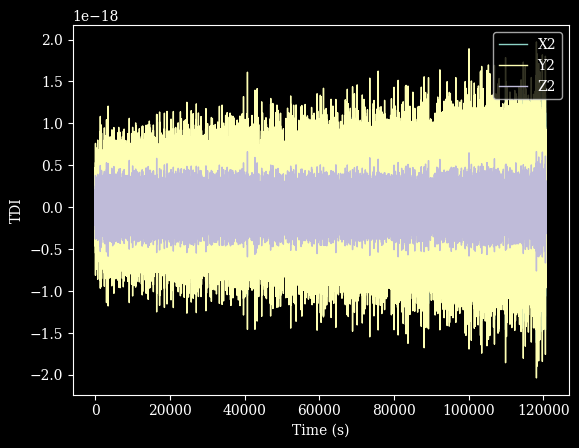

In [39]:
for channel_name in ["X2", "Y2", "Z2"]:
    plt.plot(tdi.measurements[channel_name][100:-100]/F_LASER, label=channel_name, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("TDI")
plt.legend(loc="upper right")